<a href="https://colab.research.google.com/github/MeIidon/BackpropagationBrigade/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing kaggle to download the dataset.
!pip install kaggle
# Installing wandb for tracking the project.
!pip install wandb
# Installing h5py for loading the weights.
!pip install h5py

In [ ]:
import os
import wandb
import tensorflow as tf
import numpy as np
import re
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras import datasets, layers, models, callbacks, applications, optimizers, saving
from wandb.keras import WandbCallback
from getpass import getpass
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
# We need kaggle credentials which needs to be stored in ~/.kaggle/kaggle.json
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [ ]:
# Reading in the contents of user's kaggle.json.
kaggle_secret = getpass('Enter the content of your kaggle.json: ')

# Saving into the previously created file.
with open('/root/.kaggle/kaggle.json', "w") as f:
  f.write(kaggle_secret)

In [ ]:
!wandb login

In [ ]:
# Downloading and unzipping the training dataset.
!kaggle competitions download -c tpu-getting-started
!unzip tpu-getting-started.zip -d data
!rm tpu-getting-started.zip

In [ ]:
# Image related constants.
IMAGE_SIZE = [224, 224]
NUM_OF_CLASSES = 104

# Paths to the training, validation and test datasets.
DATASET_PATH = "data"
PATH = DATASET_PATH + f"/tfrecords-jpeg-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}"
TRAINING_FILENAMES = tf.io.gfile.glob(PATH + "/train/*.tfrec")
VALIDATION_FILENAMES = tf.io.gfile.glob(PATH + "/val/*.tfrec")
TEST_FILENAMES = tf.io.gfile.glob(PATH + "/test/*.tfrec")

# Flower classes corresponding to each id (0..103).
CLASSES = [
    "pink primrose",  # 0
    "hard-leaved pocket orchid",  # 1
    "canterbury bells",  # 2
    "sweet pea",  # 3
    "wild geranium",  # 4
    "tiger lily",  # 5
    "moon orchid",  # 6
    "bird of paradise",  # 7
    "monkshood",  # 8
    "globe thistle",  # 9
    "snapdragon",  # 10
    "colt's foot",  # 11
    "king protea",  # 12
    "spear thistle",  # 13
    "yellow iris",  # 14
    "globe-flower",  # 15
    "purple coneflower",  # 16
    "peruvian lily",  # 17
    "balloon flower",  # 18
    "giant white arum lily",  # 19
    "fire lily",  # 20
    "pincushion flower",  # 21
    "fritillary",  # 22
    "red ginger",  # 23
    "grape hyacinth",  # 24
    "corn poppy",  # 25
    "prince of wales feathers",  # 26
    "stemless gentian",  # 27
    "artichoke",  # 28
    "sweet william",  # 29
    "carnation",  # 30
    "garden phlox",  # 31
    "love in the mist",  # 32
    "cosmos",  # 33
    "alpine sea holly",  # 34
    "ruby-lipped cattleya",  # 35
    "cape flower",  # 36
    "great masterwort",  # 37
    "siam tulip",  # 38
    "lenten rose",  # 39
    "barberton daisy",  # 40
    "daffodil",  # 41
    "sword lily",  # 42
    "poinsettia",  # 43
    "bolero deep blue",  # 44
    "wallflower",  # 45
    "marigold",  # 46
    "buttercup",  # 47
    "daisy",  # 48
    "common dandelion",  # 49
    "petunia",  # 50
    "wild pansy",  # 51
    "primula",  # 52
    "sunflower",  # 53
    "lilac hibiscus",  # 54
    "bishop of llandaff",  # 55
    "gaura",  # 56
    "geranium",  # 57
    "orange dahlia",  # 58
    "pink-yellow dahlia",  # 59
    "cautleya spicata",  # 60
    "japanese anemone",  # 61
    "black-eyed susan",  # 62
    "silverbush",  # 63
    "californian poppy",  # 64
    "osteospermum",  # 65
    "spring crocus",  # 66
    "iris",  # 67
    "windflower",  # 68
    "tree poppy",  # 69
    "gazania",  # 70
    "azalea",  # 71
    "water lily",  # 72
    "rose",  # 73
    "thorn apple",  # 74
    "morning glory",  # 75
    "passion flower",  # 76
    "lotus",  # 77
    "toad lily",  # 78
    "anthurium",  # 79
    "frangipani",  # 80
    "clematis",  # 81
    "hibiscus",  # 82
    "columbine",  # 83
    "desert-rose",  # 84
    "tree mallow",  # 85
    "magnolia",  # 86
    "cyclamen ",  # 87
    "watercress",  # 88
    "canna lily",  # 89
    "hippeastrum ",  # 90
    "bee balm",  # 91
    "pink quill",  # 92
    "foxglove",  # 93
    "bougainvillea",  # 94
    "camellia",  # 95
    "mallow",  # 96
    "mexican petunia",  # 97
    "bromelia",  # 98
    "blanket flower",  # 99
    "trumpet creeper",  # 100
    "blackberry lily",  # 101
    "common tulip",  # 102
    "wild rose",  # 103
]

In [ ]:
# This function converts the raw image data to a [IMAGE_SIZE, 3] shaped array
# containing the normalized color intensity values for all channels.
def decode_image(image_data):
  # Extracting the image from the dataset.
  image = tf.image.decode_jpeg(image_data, channels=3)
  # Normalizing the color intensity values.
  image = (
      tf.cast(image, tf.float32) / 255.0
  )
  # Reshaping for 3 channels.
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  return image


# This function takes a raw labelled tfrecord and converts it to decoded image data
# and one hot encoded label.
def read_labelled_tfrecord(example):
  LABELLED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "class": tf.io.FixedLenFeature([], tf.int64),
  }
  # Converting the raw data to a python dictionary with LABELLED_TFREC_FORMAT.
  example = tf.io.parse_single_example(example, LABELLED_TFREC_FORMAT)
  # Decoding the image.
  image = decode_image(example["image"])
  # One-hot encode the label of the image.
  label = tf.cast(example["class"], tf.int32)
  one_hot = tf.one_hot(label, NUM_OF_CLASSES)
  return image, one_hot


# This function takes a raw unlabelled tfrecord and converts it to decoded image data
# and the id of the test image.
def read_unlabelled_tfrecord(example):
  UNLABELLED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "id": tf.io.FixedLenFeature([], tf.string),
  }
  # Converting raw data to a python dictionary with UNLABELLED_TFREC_FORMAT.
  example = tf.io.parse_single_example(example, UNLABELLED_TFREC_FORMAT)
  # Decoding the image.
  image = decode_image(example["image"])
  id_num = example["id"]
  return image, id_num


# This function takes several filenames (tfrecords) and creates a tensorflow
# dataset from them.
def load_dataset(filenames, labelled=True, ordered=False):
  # The order of the images doesn't matter so we are turning on ignore_order
  # this results in faster loading times.
  ignore_order = tf.data.Options()
  if not ordered:
    ignore_order.experimental_deterministic = False

  # Creating the dataset. We are using parallel read option because obviously
  # it results in faster loading times.
  dataset = tf.data.TFRecordDataset(
    filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE
  )
  dataset = dataset.with_options(ignore_order)
  # The final element of the pipeline is taking the raw tfrecord
  # and converting it to labelled on unlabelled input data with the upper functions.
  dataset = dataset.map(
    read_labelled_tfrecord if labelled else read_unlabelled_tfrecord,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
  )
  return dataset

In [ ]:
# This function creates the training dataset.
# repeat will be used, this will make sure that after reaching the end record
# we go back to the first.
# BATCH_SIZE will be used.
# We will prefetch 1 batch for accellerating the reading process.
def get_training_dataset(batch_size):
  dataset = load_dataset(TRAINING_FILENAMES, labelled=True)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  return dataset


# This function creates the validation dataset.
# BATCH_SIZE will be used.
# We will prefetch 1 batch for accellerating the reading process.
def get_validation_dataset(batch_size, ordered=False):
  dataset = load_dataset(VALIDATION_FILENAMES, labelled=True, ordered=ordered)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  return dataset


# This function creates the test dataset.
# BATCH_SIZE will be used.
# We will prefetch 1 batch for accellerating the reading process.
def get_test_dataset(batch_size, ordered=False):
  dataset = load_dataset(TEST_FILENAMES, labelled=False, ordered=ordered)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  return dataset


# This function counts the number of tfrecords in a dataset.
def count_data_items(filenames):
  n = [
    int(re.compile(r"-(\d*)\.").search(filename).group(1))
    for filename in filenames
  ]
  return np.sum(n)

In [ ]:
# This will be used to calculate the number of batches needed to go through
# all the dataset in an epoch.
num_train_images = count_data_items(TRAINING_FILENAMES)
num_validation_images = count_data_items(VALIDATION_FILENAMES)

In [ ]:
sweep_config = {
    'method': 'bayes',
    'name': 'hyperopt',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'epochs': {
            'value': 20
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'h_units_1': {
            'values': np.arange(512, 2048, 128).tolist()
        },
        'h_units_2': {
            'values': np.arange(256, 1024, 64).tolist()
        },
        'h_units_3': {
            'values': np.arange(128, 512, 32).tolist()
        },
        'dropout': {
            'values': [0.1, 0.3, 0.5, 0.6]
        },
        'optimizer': {
           'values': ['adam', 'sgd']
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1
        }
    }
}

def get_optimizer(learning_rate, optimizer_str):
  if optimizer_str.lower() == 'adam':
      return optimizers.Adam(learning_rate=learning_rate)
  elif optimizer_str.lower() == 'sgd':
      return optimizers.SGD(learning_rate=learning_rate, momentum=0.1)

def get_model(config):
  # Setting seed for being able to reproduce results.
  tf.random.set_seed(42)

  # Using Transfer Learning technique for this project.
  # InceptionV3 pretrained model will be used.
  pre_trained_model = applications.InceptionV3(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')

  # Freezing the weights of the model.
  for layer in pre_trained_model.layers:
    layer.trainable = False

  # Adding our own model on top of InceptionV3.
  x = pre_trained_model.output

  # Using pooling to decrease dimension.
  x = layers.GlobalAveragePooling2D()(x)

  # Putting 3 hidden layers with optimized size.
  for h_unit in [config['h_units_1'], config['h_units_2'], config['h_units_3']]:
    x = layers.Dense(h_unit, activation='relu')(x)
    x = layers.Dropout(config['dropout'])(x)

  # The output will be a probability distribution of classes.
  x = layers.Dense(NUM_OF_CLASSES, activation='softmax')(x)

  # Creating and the final model from the pretrained model and our own model.
  model = models.Model(pre_trained_model.input, x)

  # Creating the optimizer.
  optimizer = get_optimizer(config['learning_rate'], config['optimizer'])

  # Compiling the final model.
  # Using categorical crossentropy loss function because its a classification problem.
  model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

def sweep_train(config_defaults=None):
  with wandb.init(config=config_defaults):
    # Getting the train and validation datasets.
    training_dataset = get_training_dataset(wandb.config.batch_size)
    validation_dataset = get_validation_dataset(wandb.config.batch_size)

    # Creating the model from the config values.
    model = get_model(wandb.config)

    # Training the model.
    model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=wandb.config.epochs,
        steps_per_epoch=num_train_images / wandb.config.batch_size,
        callbacks=[
            WandbCallback(),
            callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=1)
        ]
    )

sweep_id = wandb.sweep(sweep_config, project="flower_classification")
# sweep_id = 'backpropagation-brigade/flower_classification/n0nsu5hh'
wandb.agent(sweep_id, function=sweep_train, count=10)

In [ ]:
# Initializinig google drive, this is where the model will be saved.
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Getting the sweep url where the hyperparameter-optimization happened.
sweep_url = getpass('Enter the url of your sweep: ')

# Getting the sweep from wandb api.
api = wandb.Api()
sweep = api.sweep(sweep_url)

# Getting the best hyperparameter configuration for the final training.
best_run = sweep.best_run()
best_configuration = best_run.config

# Creating the model from the best configuration.
model = get_model(best_configuration)

# Getting the datasets from the configuration's batch size.
training_dataset = get_training_dataset(best_configuration['batch_size'])
validation_dataset = get_validation_dataset(best_configuration['batch_size'])

# Training the model.
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=100,
    steps_per_epoch=num_train_images / best_configuration['batch_size'],
    callbacks=[
        callbacks.ModelCheckpoint(filepath='/content/gdrive/My Drive/flower_classification/model', monitor='val_accuracy', save_best_only=True),
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
    ])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Enter the url of your sweep: ··········


wandb: Sorting runs by -summary_metrics.val_accuracy


Epoch 1/100
398/398 [==============================] - 77s 181ms/step - loss: 2.7602 - accuracy: 0.3563 - val_loss: 1.8855 - val_accuracy: 0.5264
Epoch 2/100
398/398 [==============================] - 71s 177ms/step - loss: 1.7156 - accuracy: 0.5461 - val_loss: 1.5701 - val_accuracy: 0.5838
Epoch 3/100
398/398 [==============================] - 71s 179ms/step - loss: 1.3009 - accuracy: 0.6400 - val_loss: 1.3690 - val_accuracy: 0.6269
Epoch 4/100
398/398 [==============================] - 68s 171ms/step - loss: 1.0346 - accuracy: 0.7078 - val_loss: 1.2682 - val_accuracy: 0.6670
Epoch 5/100
398/398 [==============================] - 42s 106ms/step - loss: 0.8357 - accuracy: 0.7616 - val_loss: 1.3407 - val_accuracy: 0.6511
Epoch 6/100
398/398 [==============================] - 69s 174ms/step - loss: 0.6760 - accuracy: 0.8019 - val_loss: 1.2355 - val_accuracy: 0.6818
Epoch 7/100
398/398 [==============================] - 69s 173ms/step - loss: 0.5527 - accuracy: 0.8358 - val_loss: 1.2876 -

In [ ]:
# This function displays the training and validation curves from the history data.
def display_training_curves(training, validation, title, subplot):
  if subplot % 10 == 1:
    plt.subplots(figsize=(10, 10), facecolor="#F0F0F0")
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor("#F8F8F8")
  ax.plot(training)
  ax.plot(validation)
  ax.set_title("model " + title)
  ax.set_ylabel(title)
  ax.set_xlabel("epoch")
  ax.legend(["train", "valid."])

# This function displays the confusion matrix.
def display_confusion_matrix(cmat, score, precision, recall):
  plt.figure(figsize=(15, 15))
  ax = plt.gca()
  ax.matshow(cmat, cmap="Reds")
  ax.set_xticks(range(len(CLASSES)))
  ax.set_xticklabels(CLASSES, fontdict={"fontsize": 7})
  plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
  ax.set_yticks(range(len(CLASSES)))
  ax.set_yticklabels(CLASSES, fontdict={"fontsize": 7})
  plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  title = ""
  if score is not None:
    title += "f1 = {:.3f} ".format(score)
  if precision is not None:
    title += "\nprecision = {:.3f} ".format(precision)
  if recall is not None:
    title += "\nrecall = {:.3f} ".format(recall)
  if len(title) > 0:
    ax.text(
      101,
      1,
      title,
      fontdict={
        "fontsize": 18,
        "horizontalalignment": "right",
        "verticalalignment": "top",
        "color": "#804040",
      },
    )
  plt.show()

# This function generates a confusion matrix with the model from the validation_dataset.
def generate_confusion_matrix(model, validation_dataset, number_validation_images):
  images_ds = validation_dataset.map(lambda image, label: image)
  labels_ds = validation_dataset.map(lambda image, label: label).unbatch()

  correct_labels = next(iter(labels_ds.batch(number_validation_images))).numpy()
  correct_labels = np.argmax(correct_labels, axis=-1)
  probabilities = model.predict(images_ds)
  predictions = np.argmax(probabilities, axis=-1)

  labels = range(len(CLASSES))
  cmat = confusion_matrix(correct_labels, predictions, labels=labels)
  cmat = (cmat.T / cmat.sum(axis=1)).T  # normalize

  f1 = f1_score(correct_labels, predictions, labels=labels, average="macro")
  precision = precision_score(
    correct_labels, predictions, labels=labels, average="macro"
  )
  recall = recall_score(correct_labels, predictions, labels=labels, average="macro")

  display_confusion_matrix(cmat, f1, precision, recall)

In [ ]:
# This function extracts the image and label data from a batch of images.
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    if labels.dtype == object:
      labels = [None for _ in enumerate(images)]
    return images, labels

# This function creates the title of the plot from label
# and also returns if our predictions was correct.
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
      return CLASSES[label], True
    correct = label == correct_label
    return (
      "{} [{}{}{}]".format(
          CLASSES[label],
          "OK" if correct else "NO",
          "\u2192" if not correct else "",
          CLASSES[correct_label] if not correct else "",
      ),
      correct,
    )

# This function displays one flower with prediction (red if wrong) with matplotlib.
def display_one_flower(image, title, subplot, red=False, title_size=16):
    plt.subplot(*subplot)
    plt.axis("off")
    plt.imshow(image)
    if len(title) > 0:
      plt.title(
        title,
        fontsize=int(title_size) if not red else int(title_size / 1.2),
        color="red" if red else "black",
        fontdict={"verticalalignment": "center"},
        pad=int(title_size / 1.5),
      )
    return (subplot[0], subplot[1], subplot[2] + 1)

# This function displays multiple flowers with predictions.
def display_batch_of_images(data_batch, predictions=None):
    images, labels = batch_to_numpy_images_and_labels(data_batch)
    if labels is None:
      labels = [None for _ in enumerate(images)]

    rows = int(np.sqrt(len(images)))
    cols = len(images) // rows

    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
      plt.figure(figsize=(FIGSIZE, FIGSIZE / cols * rows))
    else:
      plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE))

    for i, (image, label) in enumerate(
      zip(images[: rows * cols], labels[: rows * cols])
    ):
      title = "" if label is None else CLASSES[label]
      correct = True
      if predictions is not None:
        title, correct = title_from_label_and_target(predictions[i], label)
      dynamic_title_size = (
        FIGSIZE * SPACING / max(rows, cols) * 40 + 3
      )
      subplot = display_one_flower(
        image, title, subplot, not correct, title_size=dynamic_title_size
      )

    plt.tight_layout()
    if label is None and predictions is None:
      plt.subplots_adjust(wspace=0, hspace=0)
    else:
      plt.subplots_adjust(wspace=SPACING, hspace=SPACING)

    plt.show()

In [ ]:
# Loading the best model with keras from google drive.
best_model = saving.load_model('/content/gdrive/My Drive/flower_classification/model')

<ipython-input-15-d157fe82bd05>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


116/116 [==============================] - 13s 68ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


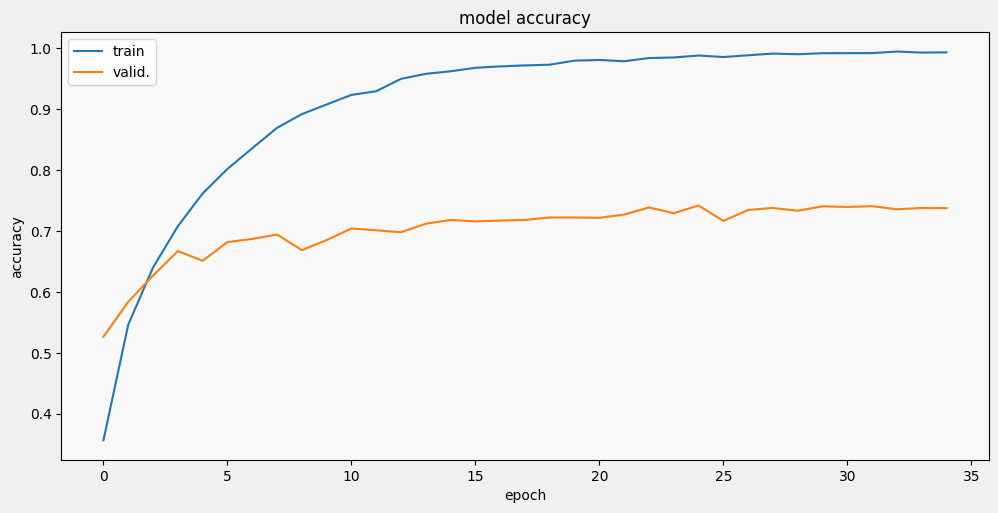

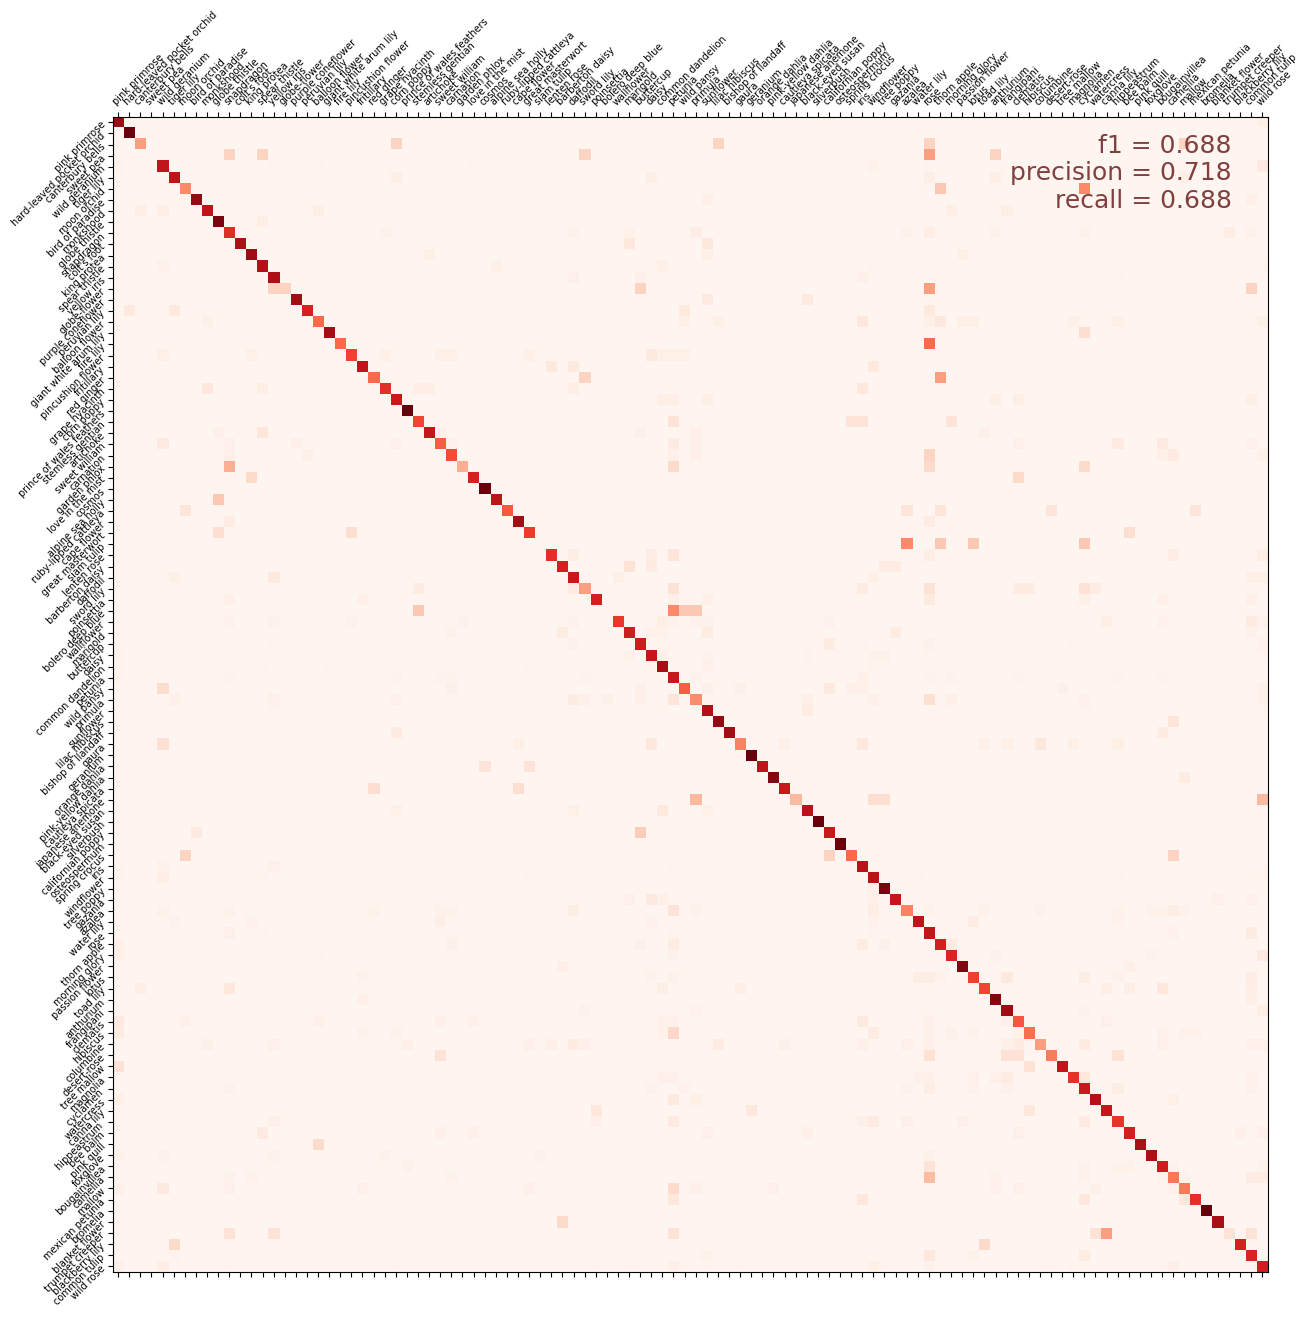

In [ ]:
# Displaying the training curve and confusion matrix for the final model.
display_training_curves(
    history.history["accuracy"],
    history.history["val_accuracy"],
    "accuracy",
    211,
)
generate_confusion_matrix(best_model, validation_dataset, num_validation_images)

1/1 [==============================] - 4s 4s/step


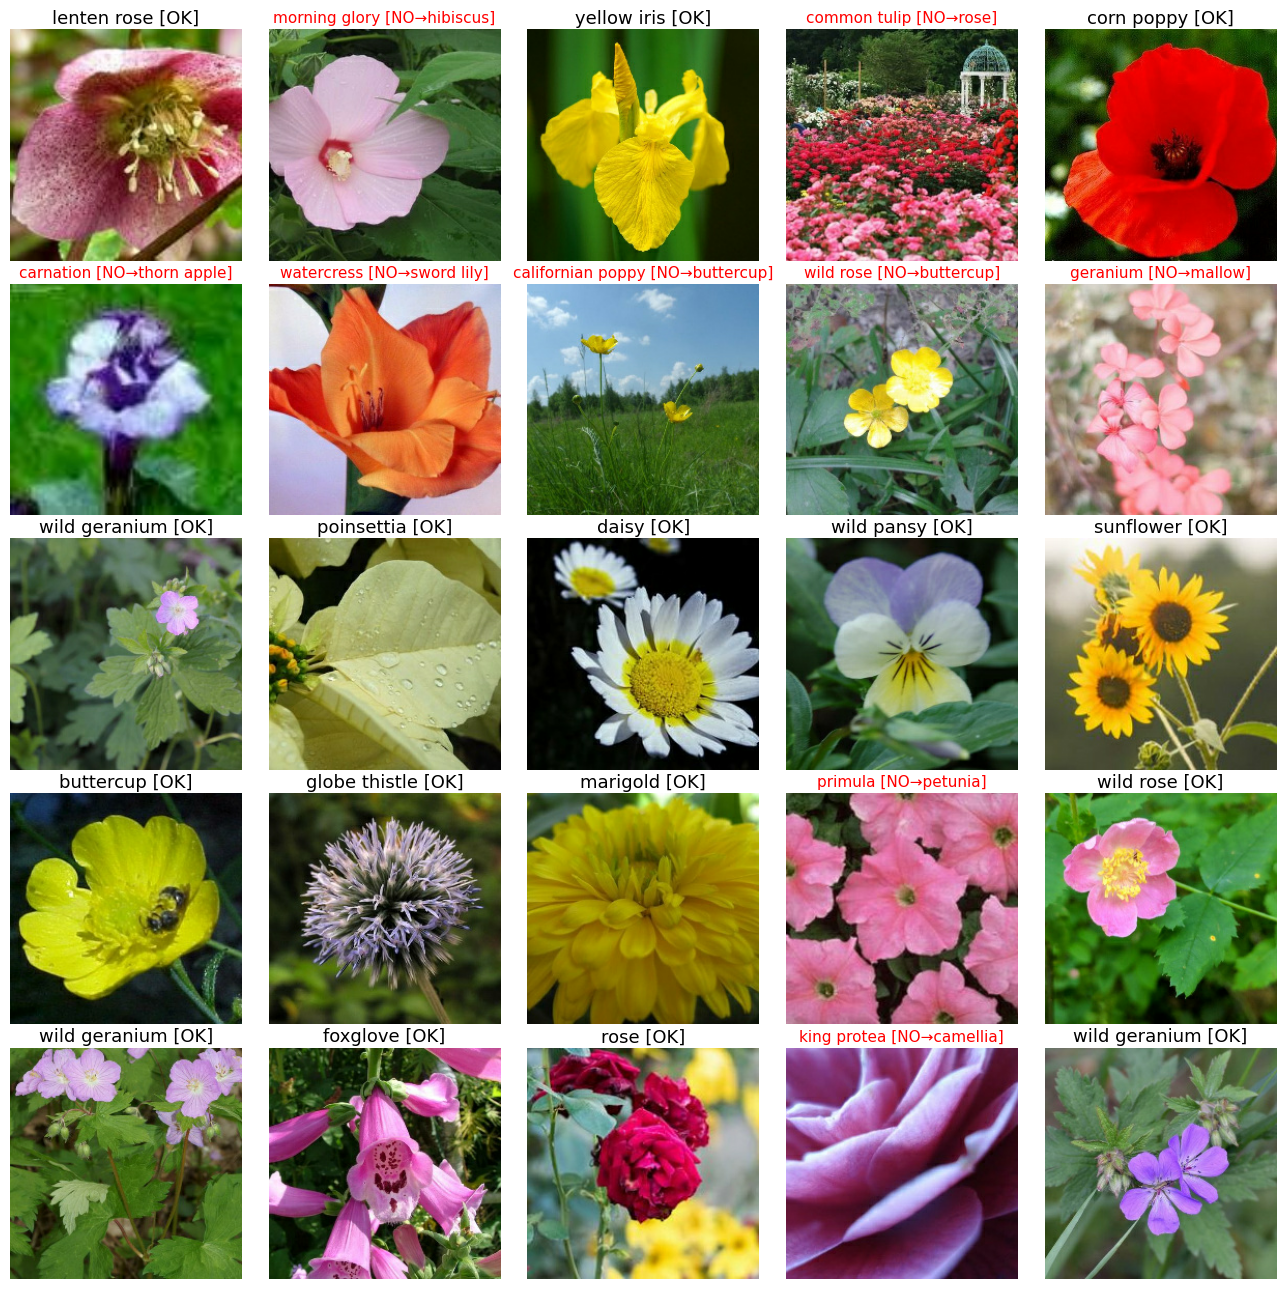

In [ ]:
# Getting a batch of validation images (25 for now).
batch = iter(get_validation_dataset(1).unbatch().batch(25))
images, labels = next(batch)
# Converting back to number from one hot encoded vector.
labels = np.argmax(labels, -1)
# Making the prediction with our model.
predictions = np.argmax(best_model.predict(images), -1)
# Displaying the images and our predictions.
display_batch_of_images((images, labels), predictions)

In [ ]:
# Creating the test dataset.
test_dataset = get_test_dataset(1)

# Making the predictions.
predictions = best_model.predict(test_dataset)

# Calculating the number of test images in the dataset.
num_test_images = count_data_items(TEST_FILENAMES)
# Unbatching.
test_ids_dataset = test_dataset.map(lambda image, idnum: idnum).unbatch()
# Getting the image ids.
test_ids = next(iter(test_ids_dataset.batch(num_test_images))).numpy().astype('U')

7382/7382 [==============================] - 112s 15ms/step


In [ ]:
# Converting predictions to the correct format.
predictions = np.argmax(predictions, -1)

# Creating the submission file.
# This results can be submitted to kaggle.
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')